In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
cd '/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S3_FacialDetection/'

/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S3_FacialDetection


In [3]:
ls

data/                 dlib_facialDetection.ipynb  model/        Untitled.txt
dlib_faceAlign.ipynb  faceBlendCommon.py          __pycache__/  web/


In [4]:
import faceBlendCommon as fbc

In [5]:
cd /content

/content


Import packages

In [6]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# from dataPath import DATA_PATH, MODEL_PATH
matplotlib.rcParams["figure.figsize"] = (6.0, 6.0)
matplotlib.rcParams["image.cmap"] = 'gray'

In [7]:
# Download 5-point alignment file
# !wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
# !bzip2 -dk shape_predictor_5_face_landmarks.dat.bz2

# Download 68-point file
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

# shutil.copy("shape_predictor_5_face_landmarks.dat", os.path.join(DATA_PATH, "model"))

--2020-08-16 12:49:41--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  18.7MB/s    in 3.3s    

2020-08-16 12:49:44 (18.7 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [8]:
MODEL_PATH = './'
# PREDICTOR_PATH = MODEL_PATH + "shape_predictor_5_face_landmarks.dat"
PREDICTOR_PATH = MODEL_PATH + "shape_predictor_68_face_landmarks.dat"

DATA_PATH = '/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S3_FacialDetection/'

RESULT_PATH = ""

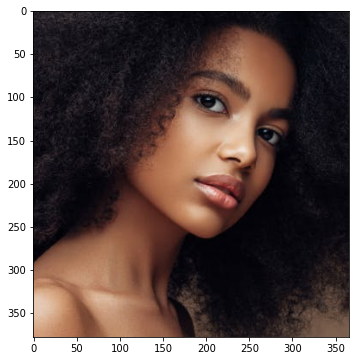

In [9]:
# read image
imageFilename = DATA_PATH + "data/face.jpg"
im = cv2.imread(imageFilename)

landmarkBasename = "results/face"

plt.imshow(im[:,:,::-1])
plt.show()

In [10]:
# Get the face detector
faceDetector = dlib.get_frontal_face_detector()
# Get the landmark detector
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)
# Detect landmarks
points = fbc.getLandmarks(faceDetector, landmarkDetector, im)
# Convert into numpy array
points = np.array(points) 

# Convert image to floating point between 0 to 1
im = np.float32(im)/255.0

In [11]:
# Dimensions of the output image
h = 600
w = 600
# Normalize image to output co-ordinates
imNorm, points = fbc.normalizeImagesAndLandmarks((h, w), im, points)

imNorm = np.uint8(imNorm * 255)

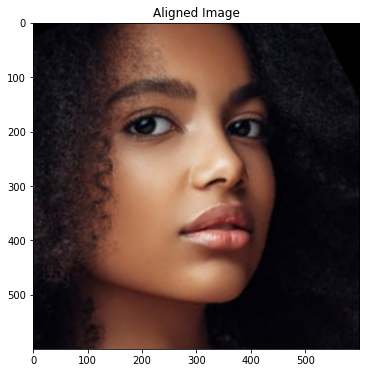

In [12]:
plt.imshow(imNorm[:,:,::-1])
plt.title("Aligned Image")
plt.show()

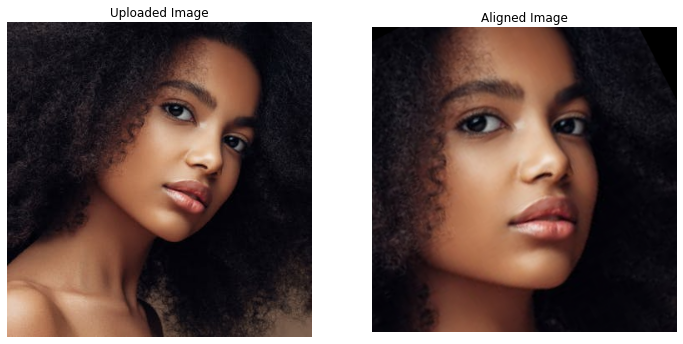

In [13]:
plt.figure(figsize=(12,6))
plt.subplot((121))
plt.imshow(im[:,:,::-1]);
plt.title("Uploaded Image")
plt.axis('off');
plt.subplot((122))
plt.imshow(imNorm[:,:,::-1]);
plt.title("Aligned Image")
plt.axis('off');

Face swap

In [15]:
# Read images
img1 = cv2.imread(DATA_PATH+"data/hulk.jpg")
img2 = cv2.imread(DATA_PATH+"data/thor.jpg")

im1Display = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
im2Display = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img1Warped = np.copy(img2)

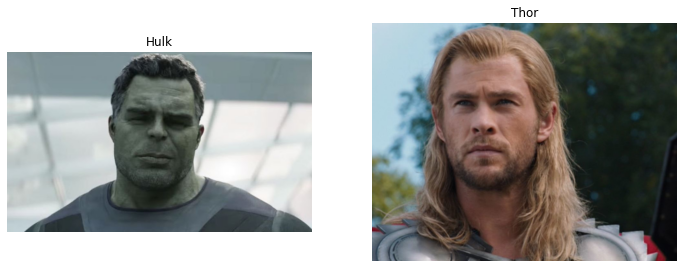

In [16]:
plt.figure(figsize=(12,6))
plt.subplot((121))
plt.imshow(im1Display);
plt.title("Hulk")
plt.axis('off');
plt.subplot((122))
plt.imshow(im2Display);
plt.title("Thor")
plt.axis('off');

In [17]:
# Face detector and landmark detector are already initialized.
# Read points from corresponding images
points1 = fbc.getLandmarks(faceDetector, landmarkDetector, img1)
points2 = fbc.getLandmarks(faceDetector, landmarkDetector, img2)

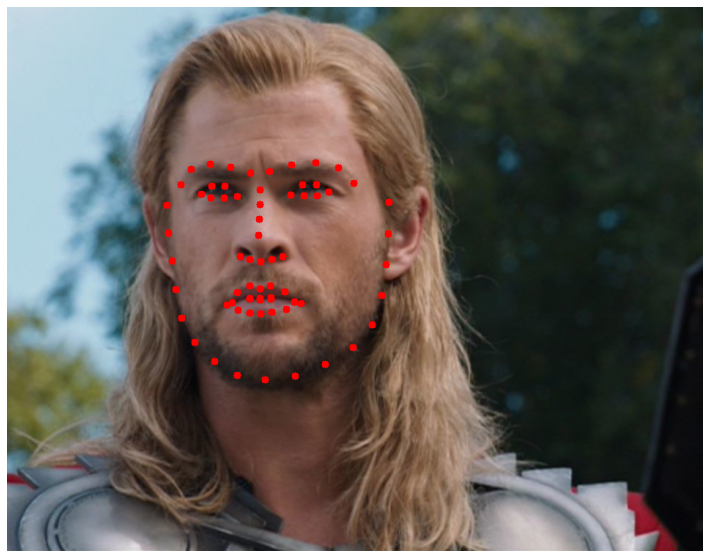

In [18]:
# Display Landmarks
imTemp = im2Display.copy()
for p in points2:
    cv2.circle(imTemp, p, 5, (255,0,0), -1)

plt.figure(figsize = (20,10)); plt.imshow(imTemp); plt.axis('off');

In [19]:
# Find convex hull
hullIndex = cv2.convexHull(np.array(points2), returnPoints=False)

# Create convex hull lists
hull1 = []
hull2 = []
for i in range(0, len(hullIndex)):
    hull1.append(points1[hullIndex[i][0]])
    hull2.append(points2[hullIndex[i][0]])

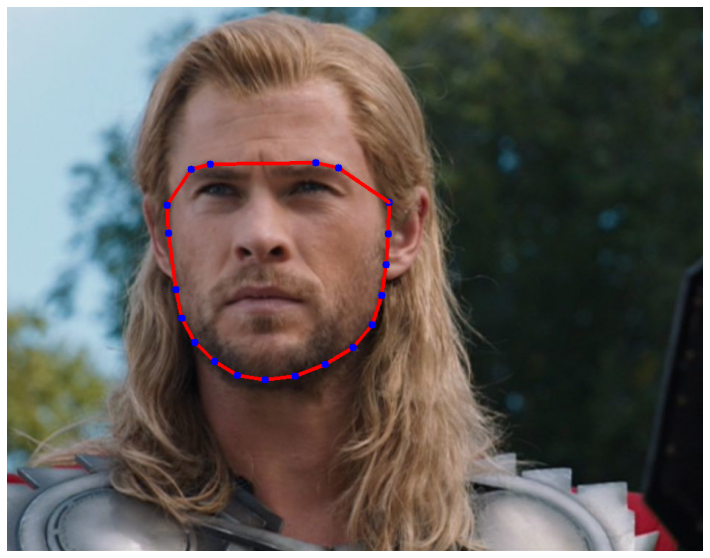

In [20]:
# Display Convex Hull
imTemp = im2Display.copy()
numPoints = len(hull2)
for i in range(0, numPoints):
    cv2.line(imTemp, hull2[i], hull2[(i+1)%numPoints], (255,0,0), 3)
    cv2.circle(imTemp, hull2[i], 5, (0,0,255), -1)
plt.figure(figsize = (20,10)); plt.imshow(imTemp); plt.axis('off');

In [21]:
# Calculate Mask for Seamless cloning
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))

mask = np.zeros(img2.shape, dtype=img2.dtype) 
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

# Find Centroid
m = cv2.moments(mask[:,:,1])
center = (int(m['m10']/m['m00']), int(m['m01']/m['m00']))

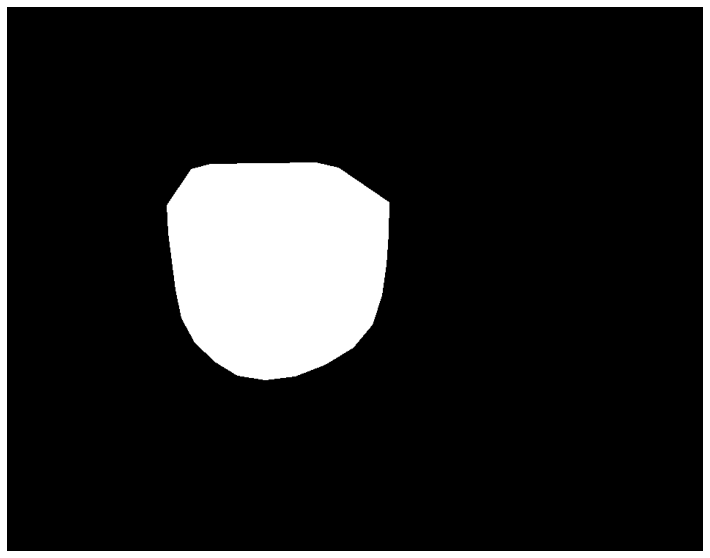

In [22]:
# Display Mask
plt.figure(figsize = (20,10)); plt.imshow(mask); plt.axis('off');

In [23]:
# Find Delaunay traingulation for convex hull points
sizeImg2 = img2.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])

dt = fbc.calculateDelaunayTriangles(rect, hull2)

# If no Delaunay Triangles were found, quit
if len(dt) == 0:
    quit()

In [24]:
imTemp1 = im1Display.copy()
imTemp2 = im2Display.copy()

tris1 = []
tris2 = []
for i in range(0, len(dt)):
    tri1 = []
    tri2 = []
    for j in range(0, 3):
        tri1.append(hull1[dt[i][j]])
        tri2.append(hull2[dt[i][j]])

    tris1.append(tri1)
    tris2.append(tri2)

cv2.polylines(imTemp1,np.array(tris1),True,(0,0,255),2);
cv2.polylines(imTemp2,np.array(tris2),True,(0,0,255),2);

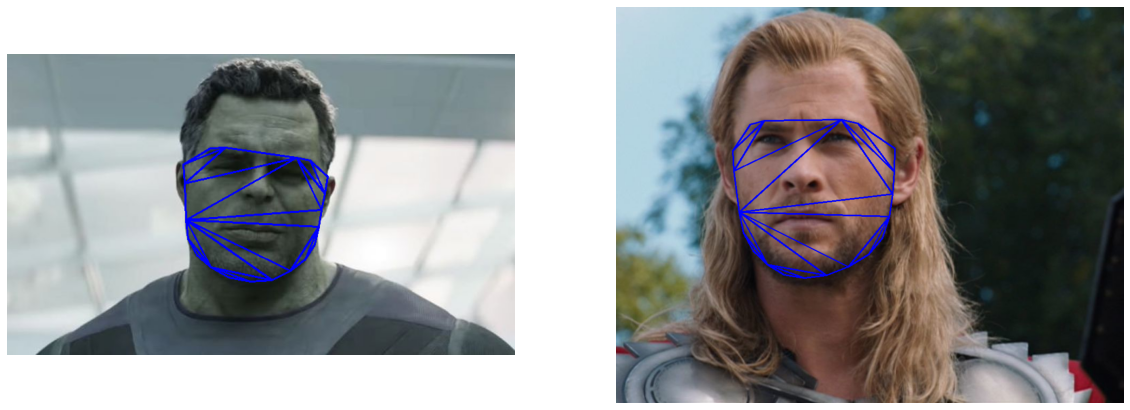

In [25]:
# Display Triangulation
plt.figure(figsize = (20,10)); 
plt.subplot(121); plt.imshow(imTemp1); plt.axis('off');
plt.subplot(122); plt.imshow(imTemp2); plt.axis('off');

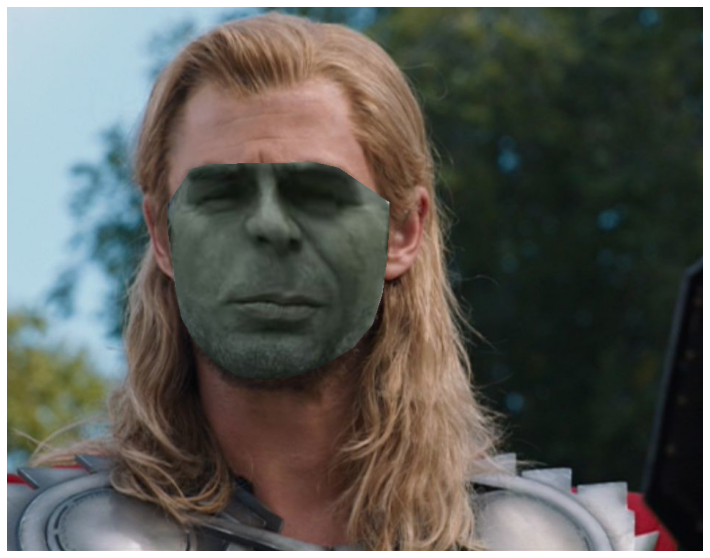

In [26]:
# Simple Alpha Blending
# Apply affine transformation to Delaunay triangles
for i in range(0, len(tris1)):
    fbc.warpTriangle(img1, img1Warped, tris1[i], tris2[i])

plt.figure(figsize=(20,10));
plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');

In [27]:
# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)

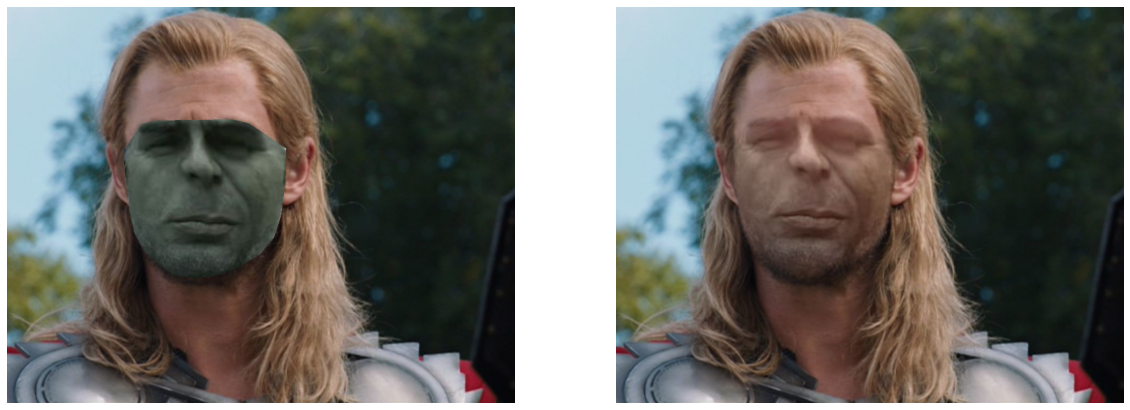

In [28]:
plt.figure(figsize=(20,10))
plt.subplot((121)); plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');
plt.subplot((122)); plt.imshow(output[:,:,::-1]); plt.axis('off');

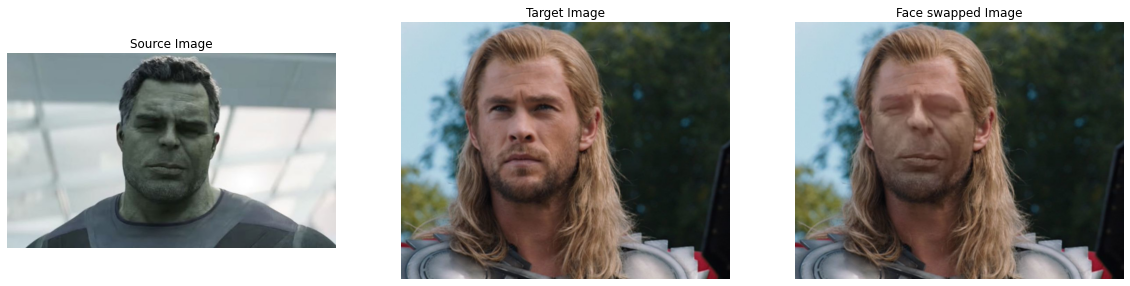

In [31]:
plt.figure(figsize=(20,10))
plt.subplot((131)); plt.imshow(im1Display); 
plt.title("Source Image")
plt.axis('off');

plt.subplot((132)); plt.imshow(im2Display);
plt.title("Target Image")
plt.axis('off');

plt.subplot((133)); plt.imshow(output[:,:,::-1]); 
plt.title("Face swapped Image")
plt.axis('off');